<a href="https://colab.research.google.com/github/stephenbeckr/convex-optimization-class/blob/master/Demos/ConvergenceRateDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convergence rate demo
Minimize $f(x)$ without any constraints

We'll compare three methods
1. Gradient descent, assuming $\nabla f$ is $L$-Lipschitz continuous (so use step $t=1/L$)
2. Nesterov accelerated gradient descent (same assumptions, same stepsize)
3. **sub-gradient** descent, assuming $f$ is $\rho$-Lipschitz, that $\|x_0-x^\star\|\le B$. If we run $k$ iterations, use stepsize $t=\frac{B}{\rho\sqrt{k}}$

We'll run this to solve a quadratic problem
$$\min_x f(x) = \frac12\|Ax-b\|_2^2$$
which satisfies $\nabla f(x) = A^T(Ax-b)$ is $L$-Lipschitz continuous with $L=\|A\|^2$,
as well as a monotonic transformation of that problem
$$\min_x g(x) = \|Ax-b\|_2$$
which satisfies $g$ is $\rho$-Lipschitz with $\rho=\|A\|$, and
$\partial g(x) = \frac{A^T(Ax-b)}{\|Ax-b\|_2}$ if $Ax-b\neq 0$.

Let $A$ be $m\times n$ in size. We'll consider two cases:
1. Underdetermined, $m<n$, then $f$ is not strongly convex
2. Overdetermiend, $m>n$, then if $A$ is a Gaussian, with probability 1 $f$ is strongly convex.

We expect different types of convergence:
1. sublinear, where error $\propto 1/k^\alpha$ for $\alpha>0$
2. linear, where error $\propto \rho^k$ for some $\rho = 1-1/\kappa$ or $\rho = 1- 1/\sqrt{\kappa}$.

In [1]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
rng   = np.random.default_rng()

##Solvers

In [68]:
def gradientDescent(f,grad,stepsize,x0,maxiter=1e3):
  x = x0.copy()
  fHist = []
  for k in range(int(maxiter)):
    x -= stepsize*grad(x)
    fHist.append( f(x) )
  return x, fHist

def NesterovGradientDescent(f,grad,stepsize,x0,maxiter=1e3,restart=np.Inf):
  x = x0.copy()
  y = x.copy()
  fHist = []
  kk = 0
  for k in range(int(maxiter)):
    xOld = x.copy()
    x = y - stepsize*grad(y)
    kk = kk + 1
    if kk > restart:
      kk = 0
    y = x + kk/(kk+3)*(x-xOld)
    fHist.append( f(x) )
  return x, fHist

## Undeterdetermined case (expect gradient descent to give sublinear convergence)

In [101]:
rng   = np.random.default_rng(1)
m   = 49
n   = 50
A   = rng.normal( size=(m,n) )
xStar = np.ones( (n,1) )
#b   = rng.normal( size=(m,1) )
b   = A@xStar
L   = norm(A,ord=2)**2
# For gradient descent on 1/2||Ax-b||^2
f   = lambda x : norm(A@x-b)**2/2
grad= lambda x : A.T@( A@x-b )

fStar   = 0
x0      = np.zeros((n,1))

# And if we do subgradient descent on ||Ax-b||
# (Note: if we measure f2(x) convergence, since it's not squared
#  we'd of course at least expect sqrt() slower... )
f2  = lambda x : norm(A@x-b)
def subgrad(x):
  r = A@x-b
  return A.T@(r/norm(r))
rho  = norm(A,ord=2)
B    = norm(xStar-x0)

In [102]:
maxiter = 1e4
x_gd, fHist_gd     = gradientDescent(f,grad,1/L,x0,maxiter=maxiter)
x_Nest, fHist_Nest = NesterovGradientDescent(f,grad,1/L,x0,maxiter=maxiter)
# subgradient descent:
step = B/rho/np.sqrt(maxiter)
x_sgd, fHist_sgd   = gradientDescent(f2,subgrad,step,x0,maxiter=maxiter)

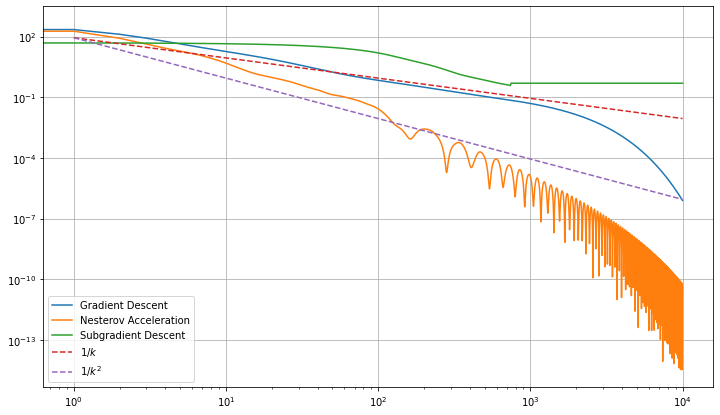

In [103]:
plt.figure(figsize=(12,7))
plt.loglog( fHist_gd, label='Gradient Descent' )
plt.loglog( fHist_Nest, label='Nesterov Acceleration' )
plt.loglog( fHist_sgd, label='Subgradient Descent' )
k = np.arange(1,maxiter)
plt.loglog(k,90/k,'--',label='$1/k$')
plt.loglog(k,90/k**2,'--',label='$1/k^2$')
plt.legend()
plt.grid()
plt.show()

#### Question for thought:
The convergence rate of gardient descent and Nesterov acceleration seems to improve eventually.  Why?

A: This is probably because the algorithm has identified the right manifold (e.g., the support of $x^\star$) which effectively reduces the dimensionality, and hence we start acting like an over-determined least-squares problem, hence strongly convex.  See [Are we there yet? Manifold identification of gradient-related proximal methods](http://proceedings.mlr.press/v89/sun19a.html) ICML '19.

## Over-determined case, expect linear convergence

In [138]:
rng   = np.random.default_rng(1)
m   = 55
n   = 50
A   = rng.normal( size=(m,n) )
xStar = np.ones( (n,1) )
b   = A@xStar
L   = norm(A,ord=2)**2
# For gradient descent on 1/2||Ax-b||^2
f   = lambda x : norm(A@x-b)**2/2
grad= lambda x : A.T@( A@x-b )

fStar   = 0
x0      = np.zeros((n,1))

evals = np.linalg.eigvals(A.T@A)
L     = np.max(evals)
mu    = np.min(evals)
kappa = L/mu
print(f"L is {L:.2f}, mu is {mu:.2f}, condition number is {kappa:.2e}")

f2  = lambda x : norm(A@x-b)
def subgrad(x):
  r = A@x-b
  return A.T@(r/norm(r))
rho  = norm(A,ord=2)
B    = norm(xStar-x0)

L is 204.96, mu is 0.17, condition number is 1.17e+03


In [144]:
maxiter = 1e4
x_gd, fHist_gd     = gradientDescent(f,grad,1/L,x0,maxiter=maxiter)
x_Nest, fHist_Nest = NesterovGradientDescent(f,grad,1/L,x0,maxiter=maxiter)
x_Nest2, fHist_Nest2 = NesterovGradientDescent(f,grad,1/L,x0,maxiter=maxiter,restart=500)
# subgradient descent:
step = 1e0*(B/rho)/np.sqrt(maxiter)
x_sgd, fHist_sgd   = gradientDescent(f2,subgrad,step,x0,maxiter=maxiter)

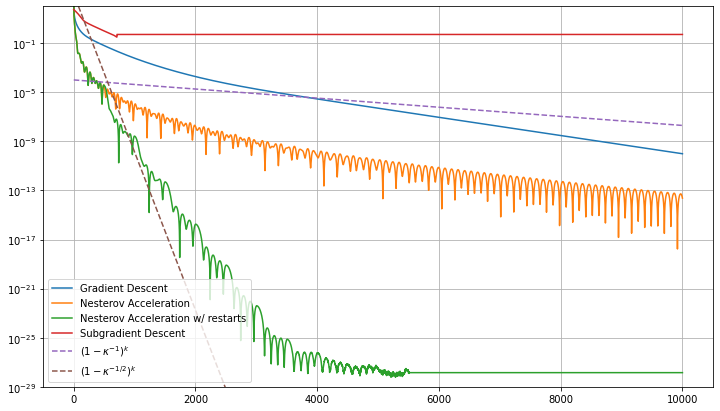

In [145]:
plt.figure(figsize=(12,7))
plt.semilogy( fHist_gd, label='Gradient Descent' )
plt.semilogy( fHist_Nest, label='Nesterov Acceleration' )
plt.semilogy( fHist_Nest2, label='Nesterov Acceleration w/ restarts' )
plt.semilogy( fHist_sgd, label='Subgradient Descent' )
k = np.arange(1,maxiter)
plt.semilogy(k,1e-4*(1-1/kappa)**k,'--',label='$(1-\kappa^{-1})^k$')
plt.semilogy(k,1e3*(1-1/np.sqrt(kappa))**k,'--',label='$(1-\kappa^{-1/2})^k$')
plt.ylim(bottom=1e-29,top=1e2)
plt.legend()
plt.grid()
plt.show()